<a href="https://colab.research.google.com/github/Leonel58/MACHINE_LEARNING_PYTHON/blob/master/trafico_red_analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import gzip
import os

# Ruta del archivo
file_path = "/content/maccdc2012_00001.pcap.gz"
output_path = "/content/maccdc2012_00001.pcap"

# Descomprimir si no está ya descomprimido
if not os.path.exists(output_path):
    with gzip.open(file_path, 'rb') as f_in:
        with open(output_path, 'wb') as f_out:
            f_out.write(f_in.read())
    print("Archivo descomprimido")
else:
    print("Archivo ya descomprimido")

Archivo ya descomprimido


In [15]:
!pip install pyspark scapy

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
import scapy.all as scapy
from io import BytesIO
import pandas as pd

# Crear sesión de Spark
spark = SparkSession.builder \
    .appName("PCAP Analysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()

# Definir esquema para los datos
schema = StructType([
    StructField("timestamp", DoubleType(), True),
    StructField("src_ip", StringType(), True),
    StructField("dst_ip", StringType(), True),
    StructField("src_port", IntegerType(), True),
    StructField("dst_port", IntegerType(), True),
    StructField("protocol", StringType(), True),
    StructField("length", IntegerType(), True),
    StructField("flags", StringType(), True)
])

def process_pcap_chunk(pcap_path, max_packets=10000):
    """Procesa un chunk del PCAP y devuelve lista de paquetes"""
    packets_data = []
    packets = scapy.rdpcap(pcap_path, count=max_packets)

    for pkt in packets:
        row = {}
        row["timestamp"] = float(pkt.time)
        row["length"] = len(pkt)

        # Extraer IP
        if scapy.IP in pkt:
            row["src_ip"] = pkt[scapy.IP].src
            row["dst_ip"] = pkt[scapy.IP].dst
            row["protocol"] = pkt[scapy.IP].proto

            # Extraer puertos si es TCP/UDP
            if scapy.TCP in pkt:
                row["src_port"] = pkt[scapy.TCP].sport
                row["dst_port"] = pkt[scapy.TCP].dport
                row["flags"] = str(pkt[scapy.TCP].flags)
            elif scapy.UDP in pkt:
                row["src_port"] = pkt[scapy.UDP].sport
                row["dst_port"] = pkt[scapy.UDP].dport
                row["flags"] = "UDP"
        else:
            continue

        packets_data.append(row)

    return packets_data

# Procesar en chunks
print("Procesando PCAP en chunks...")
all_data = []
chunk_size = 5000

# Procesar todo el archivo en chunks
packets = []
for i in range(0, 100000, chunk_size):  # Ajusta el rango según sea necesario
    try:
        chunk_packets = scapy.rdpcap(output_path, count=chunk_size)
        if not chunk_packets:
            break

        for pkt in chunk_packets:
            row = {}
            row["timestamp"] = float(pkt.time)
            row["length"] = len(pkt)

            if scapy.IP in pkt:
                row["src_ip"] = pkt[scapy.IP].src
                row["dst_ip"] = pkt[scapy.IP].dst
                row["protocol"] = str(pkt[scapy.IP].proto)

                if scapy.TCP in pkt:
                    row["src_port"] = pkt[scapy.TCP].sport
                    row["dst_port"] = pkt[scapy.TCP].dport
                    row["flags"] = str(pkt[scapy.TCP].flags)
                elif scapy.UDP in pkt:
                    row["src_port"] = pkt[scapy.UDP].sport
                    row["dst_port"] = pkt[scapy.UDP].dport
                    row["flags"] = "UDP"
                else:
                    row["src_port"] = None
                    row["dst_port"] = None
                    row["flags"] = None

                packets.append(row)

        print(f"Procesados {len(packets)} paquetes...")

    except Exception as e:
        print(f"Error en chunk {i}: {e}")
        break

# Crear DataFrame de Spark
if packets:
    # Primero crear un pandas DataFrame
    pdf = pd.DataFrame(packets)

    # Luego convertir a Spark DataFrame
    df = spark.createDataFrame(pdf)

    print(f"DataFrame creado con {df.count()} filas")
    df.show(10)

    # Análisis básico
    print("\n=== ESTADÍSTICAS ===")
    df.createOrReplaceTempView("network_traffic")

    # Top IPs origen
    spark.sql("""
        SELECT src_ip, COUNT(*) as packet_count,
               SUM(length) as total_bytes
        FROM network_traffic
        WHERE src_ip IS NOT NULL
        GROUP BY src_ip
        ORDER BY packet_count DESC
        LIMIT 10
    """).show()

    # Top IPs destino
    spark.sql("""
        SELECT dst_ip, COUNT(*) as packet_count,
               SUM(length) as total_bytes
        FROM network_traffic
        WHERE dst_ip IS NOT NULL
        GROUP BY dst_ip
        ORDER BY packet_count DESC
        LIMIT 10
    """).show()

    # Protocolos
    spark.sql("""
        SELECT protocol, COUNT(*) as count
        FROM network_traffic
        WHERE protocol IS NOT NULL
        GROUP BY protocol
        ORDER BY count DESC
    """).show()

    # Guardar resultados
    df.write.mode("overwrite").parquet("/content/pcap_analysis.parquet")
    print("Resultados guardados en /content/pcap_analysis.parquet")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.9 MB/s eta 0:00:00
Procesando PCAP en chunks...
Procesados 4978 paquetes...
Procesados 9956 paquetes...
Procesados 14934 paquetes...
Procesados 19912 paquetes...
Procesados 24890 paquetes...
Procesados 29868 paquetes...
Procesados 34846 paquetes...
Procesados 39824 paquetes...
Procesados 44802 paquetes...
Procesados 49780 paquetes...
Procesados 54758 paquetes...
Procesados 59736 paquetes...
Procesados 64714 paquetes...
Procesados 69692 paquetes...
Procesados 74670 paquetes...
Procesados 79648 paquetes...
Procesados 84626 paquetes...
Procesados 89604 paquetes...
Procesados 94582 paquetes...
Procesados 99560 paquetes...
DataFrame creado con 99560 filas
+---------------+------+--------------+--------------+--------+--------+--------+-----+
|      timestamp|length|        src_ip|        dst_ip|protocol|src_port|dst_port|flags|
+---------------+------+--------------+--------------+--------+--------+--------+-----+
|1.33190460778E9|  

In [18]:
df.show(30)

+---------------+------+--------------+--------------+--------+--------+--------+-----+
|      timestamp|length|        src_ip|        dst_ip|protocol|src_port|dst_port|flags|
+---------------+------+--------------+--------------+--------+--------+--------+-----+
|1.33190460778E9|  1438|192.168.202.68|192.168.24.100|       6|  8080.0|  1038.0|    A|
|1.33190460778E9|  1438|192.168.202.68|192.168.24.100|       6|  8080.0|  1038.0|    A|
|1.33190460778E9|  1438|192.168.202.68|192.168.24.100|       6|  8080.0|  1038.0|    A|
|1.33190460778E9|    64|192.168.24.100|192.168.202.68|       6|  1038.0|  8080.0|    A|
|1.33190460778E9|  1438|192.168.202.68|192.168.24.100|       6|  8080.0|  1038.0|    A|
|1.33190460778E9|  1438|192.168.202.68|192.168.24.100|       6|  8080.0|  1038.0|    A|
|1.33190460778E9|  1438|192.168.202.68|192.168.24.100|       6|  8080.0|  1038.0|    A|
|1.33190460778E9|  1438|192.168.202.68|192.168.24.100|       6|  8080.0|  1038.0|    A|
|1.33190460778E9|  1438|192.168.

In [20]:
# ANÁLISIS ADICIONAL POR SI NECESITAS

# 1. Buscar comunicaciones específicas
def analyze_communication(ip_address):
    """Analiza todo el tráfico relacionado con una IP específica"""
    print(f"\nANÁLISIS PARA IP: {ip_address}")

    # Tráfico donde la IP es origen
    traffic_from = df.filter(df.src_ip == ip_address)
    print(f"• Como ORIGEN: {traffic_from.count():,} paquetes")

    # Tráfico donde la IP es destino
    traffic_to = df.filter(df.dst_ip == ip_address)
    print(f"• Como DESTINO: {traffic_to.count():,} paquetes")

    # Puertos destino contactados
    if traffic_from.count() > 0:
        ports = traffic_from.groupBy("dst_port") \
            .agg(count("*").alias("paquetes")) \
            .orderBy(desc("paquetes"))
        print("\nPuertos destino contactados:")
        ports.show(10)

    return traffic_from, traffic_to

# 2. Análisis de throughput por intervalo de tiempo
from pyspark.sql.functions import window

# Agrupar por ventanas de tiempo (ej: 5 minutos)
if 'datetime' in df.columns:
    throughput = df_time.groupBy(
        window("datetime", "5 minutes").alias("ventana_tiempo")
    ).agg(
        count("*").alias("paquetes"),
        spark_sum("length").alias("bytes")
    ).orderBy("ventana_tiempo")

    print("\nTHROUGHPUT POR INTERVALOS DE 5 MINUTOS:")
    throughput.show(10, truncate=False)

# 3. Exportar datos completos para análisis externo
print("\nEXPORTANDO DATOS PARA ANÁLISIS EXTERNO...")

# Guardar DataFrame completo en formato Parquet (eficiente)
df.write.mode("overwrite").parquet("/content/datos_completos.parquet")
print("✓ Datos completos guardados en: /content/datos_completos.parquet")

# Guardar en CSV (si no es muy grande)
try:
    df.limit(100000).write.mode("overwrite").csv("/content/muestra_datos.csv", header=True)
    print("✓ Muestra de datos guardada en CSV")
except:
    print("⚠️ No se pudo guardar CSV completo, archivo muy grande")


EXPORTANDO DATOS PARA ANÁLISIS EXTERNO...
✓ Datos completos guardados en: /content/datos_completos.parquet
✓ Muestra de datos guardada en CSV


In [21]:
# PRIMERO, ASEGURAR QUE TENEMOS EL DATAFRAME df
print(f"DataFrame disponible: {'df' in locals()}")
print(f"Número de filas: {df.count()}")
df.show(5)

DataFrame disponible: True
Número de filas: 99560
+---------------+------+--------------+--------------+--------+--------+--------+-----+
|      timestamp|length|        src_ip|        dst_ip|protocol|src_port|dst_port|flags|
+---------------+------+--------------+--------------+--------+--------+--------+-----+
|1.33190460778E9|  1438|192.168.202.68|192.168.24.100|       6|  8080.0|  1038.0|    A|
|1.33190460778E9|  1438|192.168.202.68|192.168.24.100|       6|  8080.0|  1038.0|    A|
|1.33190460778E9|  1438|192.168.202.68|192.168.24.100|       6|  8080.0|  1038.0|    A|
|1.33190460778E9|    64|192.168.24.100|192.168.202.68|       6|  1038.0|  8080.0|    A|
|1.33190460778E9|  1438|192.168.202.68|192.168.24.100|       6|  8080.0|  1038.0|    A|
+---------------+------+--------------+--------------+--------+--------+--------+-----+
only showing top 5 rows


In [22]:
# AHORA, RECALCULAR LAS ESTADÍSTICAS NECESARIAS PARA VISUALIZACIÓN
from pyspark.sql.functions import count, desc, sum as spark_sum, hour, from_unixtime, mean
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
# 1. Top IPs Origen
print("\nCalculando Top IPs Origen...")
top_src_ips = df.groupBy("src_ip") \
    .agg(
        count("*").alias("num_paquetes"),
        spark_sum("length").alias("bytes_totales"),
        mean("length").alias("tamaño_promedio")
    ) \
    .orderBy(desc("num_paquetes")) \
    .limit(10)

print("Top 10 IPs Origen:")
top_src_ips.show(truncate=False)


Calculando Top IPs Origen...
Top 10 IPs Origen:
+---------------+------------+-------------+------------------+
|src_ip         |num_paquetes|bytes_totales|tamaño_promedio   |
+---------------+------------+-------------+------------------+
|192.168.202.83 |20220       |1576140      |77.94955489614243 |
|192.168.206.44 |20040       |1283680      |64.0558882235529  |
|192.168.204.45 |12460       |818080       |65.65650080256822 |
|192.168.202.68 |9680        |12413680     |1282.404958677686 |
|192.168.202.110|9240        |782200       |84.65367965367966 |
|192.168.27.100 |6180        |395640       |64.01941747572816 |
|192.168.24.100 |3940        |273320       |69.37055837563452 |
|192.168.27.253 |3940        |4462420      |1132.5939086294416|
|192.168.203.45 |1680        |1564900      |931.4880952380952 |
|192.168.203.61 |1120        |214480       |191.5             |
+---------------+------------+-------------+------------------+



In [24]:
# 2. Distribución por hora
print("\nCalculando distribución por hora...")
df_time = df.withColumn("datetime", from_unixtime("timestamp"))
df_time = df_time.withColumn("hour", hour("datetime"))

hour_distribution = df_time.groupBy("hour") \
    .agg(count("*").alias("paquetes")) \
    .orderBy("hour")

print("Distribución por hora:")
hour_distribution.show(24, truncate=False)


Calculando distribución por hora...
Distribución por hora:
+----+--------+
|hour|paquetes|
+----+--------+
|13  |99560   |
+----+--------+



In [25]:

# 3. Top Puertos Destino
print("\nCalculando Top Puertos Destino...")
top_dst_ports = df.filter(df.dst_port.isNotNull()) \
    .groupBy("dst_port") \
    .agg(
        count("*").alias("num_paquetes"),
        spark_sum("length").alias("bytes_totales"),
        mean("length").alias("tamaño_promedio")
    ) \
    .orderBy(desc("num_paquetes")) \
    .limit(15)

print("Top 15 Puertos Destino:")
top_dst_ports.show(truncate=False)


Calculando Top Puertos Destino...
Top 15 Puertos Destino:
+--------+------------+-------------+------------------+
|dst_port|num_paquetes|bytes_totales|tamaño_promedio   |
+--------+------------+-------------+------------------+
|1038.0  |8660        |12255360     |1415.1685912240184|
|41936.0 |7780        |497920       |64.0              |
|8080.0  |3560        |235720       |66.21348314606742 |
|443.0   |3320        |399520       |120.33734939759036|
|49662.0 |2760        |4023580      |1457.8188405797102|
|5432.0  |1500        |146920       |97.94666666666667 |
|36694.0 |800         |129880       |162.35            |
|55554.0 |800         |146720       |183.4             |
|80.0    |420         |36960        |88.0              |
|139.0   |380         |38360        |100.94736842105263|
|32887.0 |360         |389280       |1081.3333333333333|
|34459.0 |360         |380160       |1056.0            |
|34465.0 |360         |380160       |1056.0            |
|41438.0 |360         |380160


Tomando muestra de tamaños de paquetes...


DataFrame disponible: True
Número de filas: 99560
+---------------+------+--------------+--------------+--------+--------+--------+-----+
|      timestamp|length|        src_ip|        dst_ip|protocol|src_port|dst_port|flags|
+---------------+------+--------------+--------------+--------+--------+--------+-----+
|1.33190460778E9|  1438|192.168.202.68|192.168.24.100|       6|  8080.0|  1038.0|    A|
|1.33190460778E9|  1438|192.168.202.68|192.168.24.100|       6|  8080.0|  1038.0|    A|
|1.33190460778E9|  1438|192.168.202.68|192.168.24.100|       6|  8080.0|  1038.0|    A|
|1.33190460778E9|    64|192.168.24.100|192.168.202.68|       6|  1038.0|  8080.0|    A|
|1.33190460778E9|  1438|192.168.202.68|192.168.24.100|       6|  8080.0|  1038.0|    A|
+---------------+------+--------------+--------------+--------+--------+--------+-----+
only showing top 5 rows

Calculando Top IPs Origen...
Top 10 IPs Origen:
+---------------+------------+-------------+------------------+
|src_ip         |num_

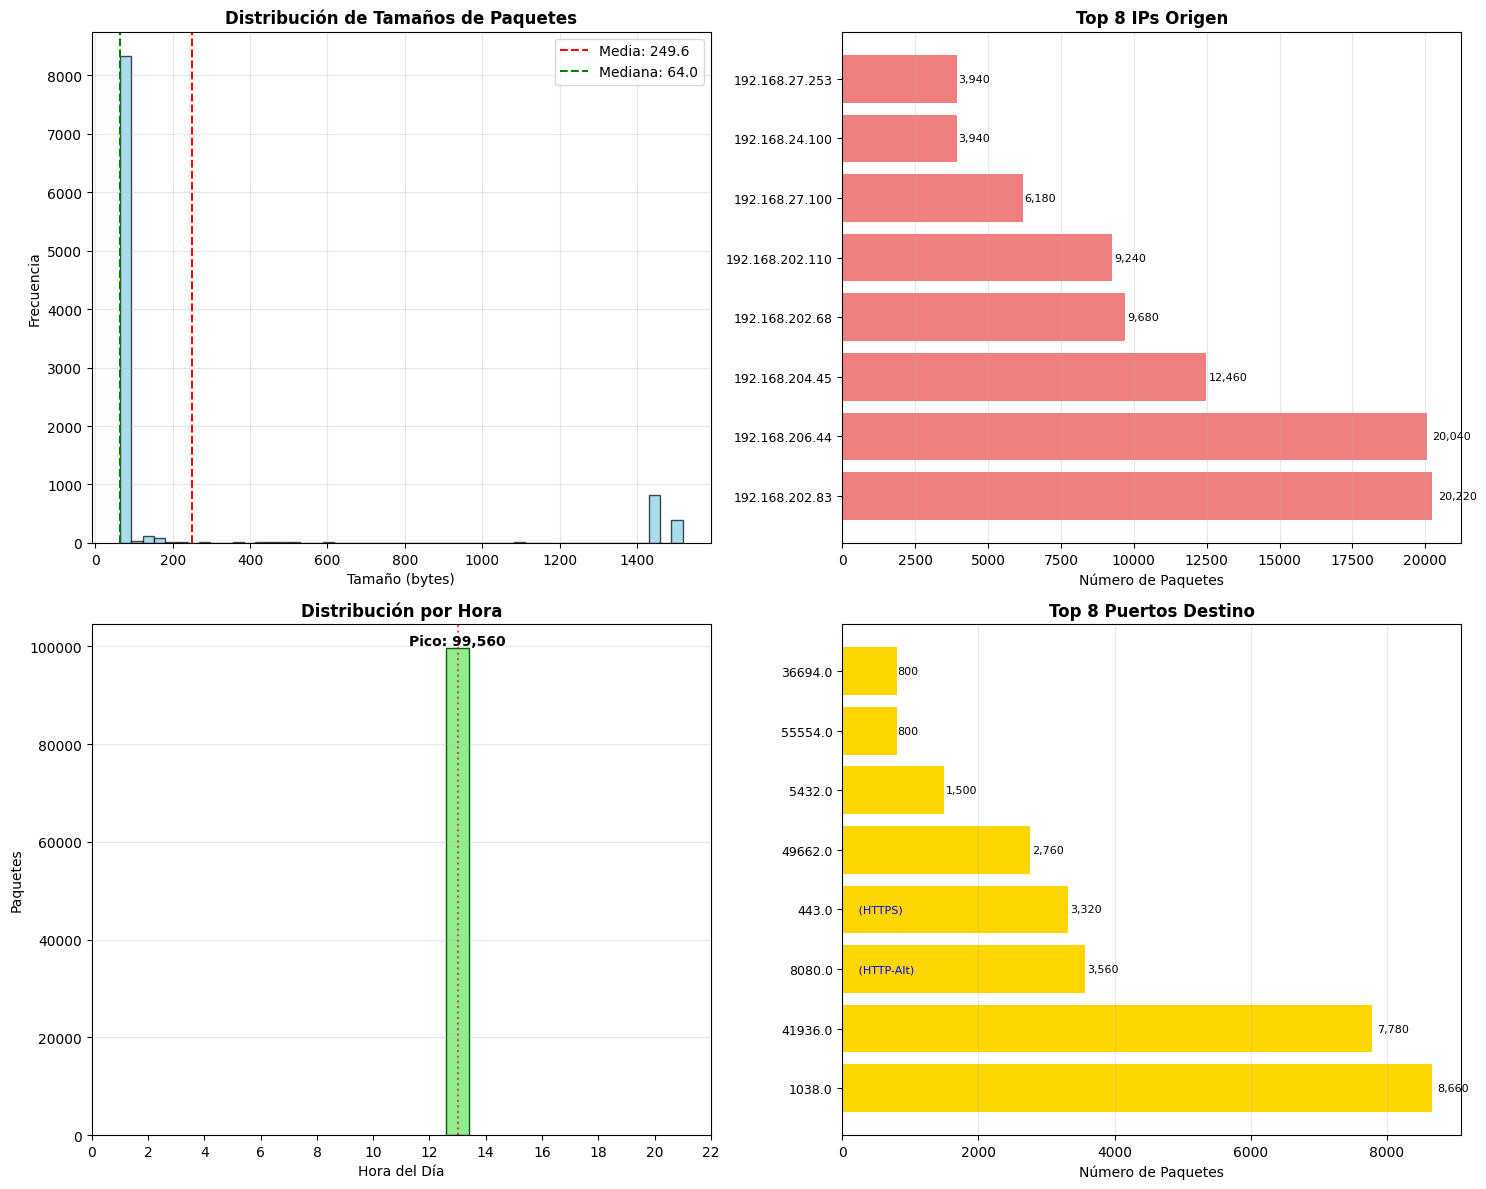

✓ Visualización principal guardada en: /content/estadisticas_red_completas.png

Generando gráfico de dispersión tiempo vs tamaño...


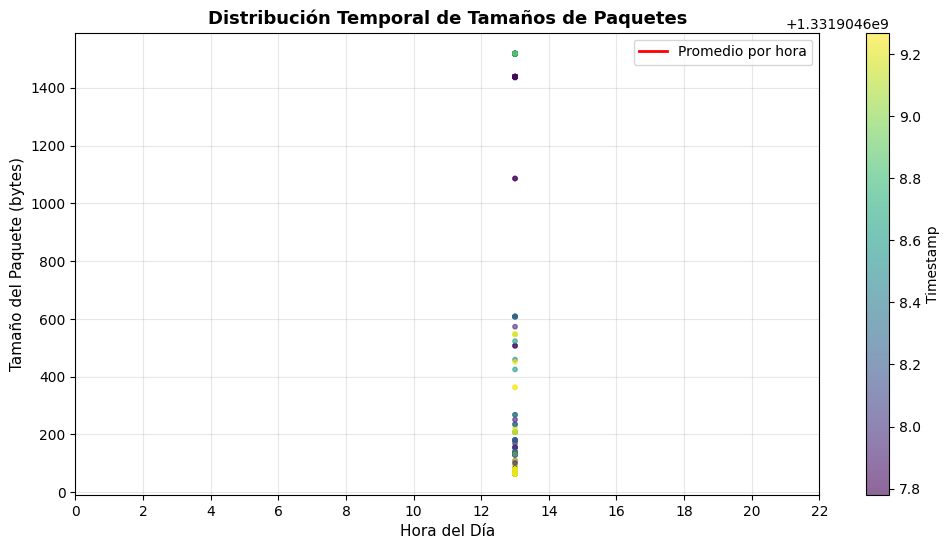

✓ Gráfico de dispersión guardado en: /content/dispersion_tiempo_tamaño.png

Generando gráfico de protocolos...


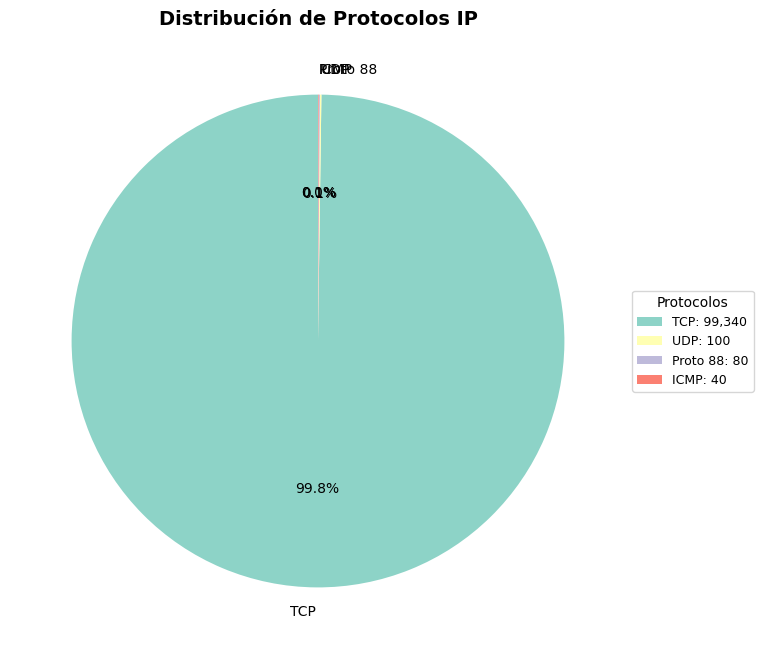

✓ Gráfico de protocolos guardado en: /content/distribucion_protocolos.png

Generando gráfico de throughput...


<Figure size 1400x600 with 0 Axes>

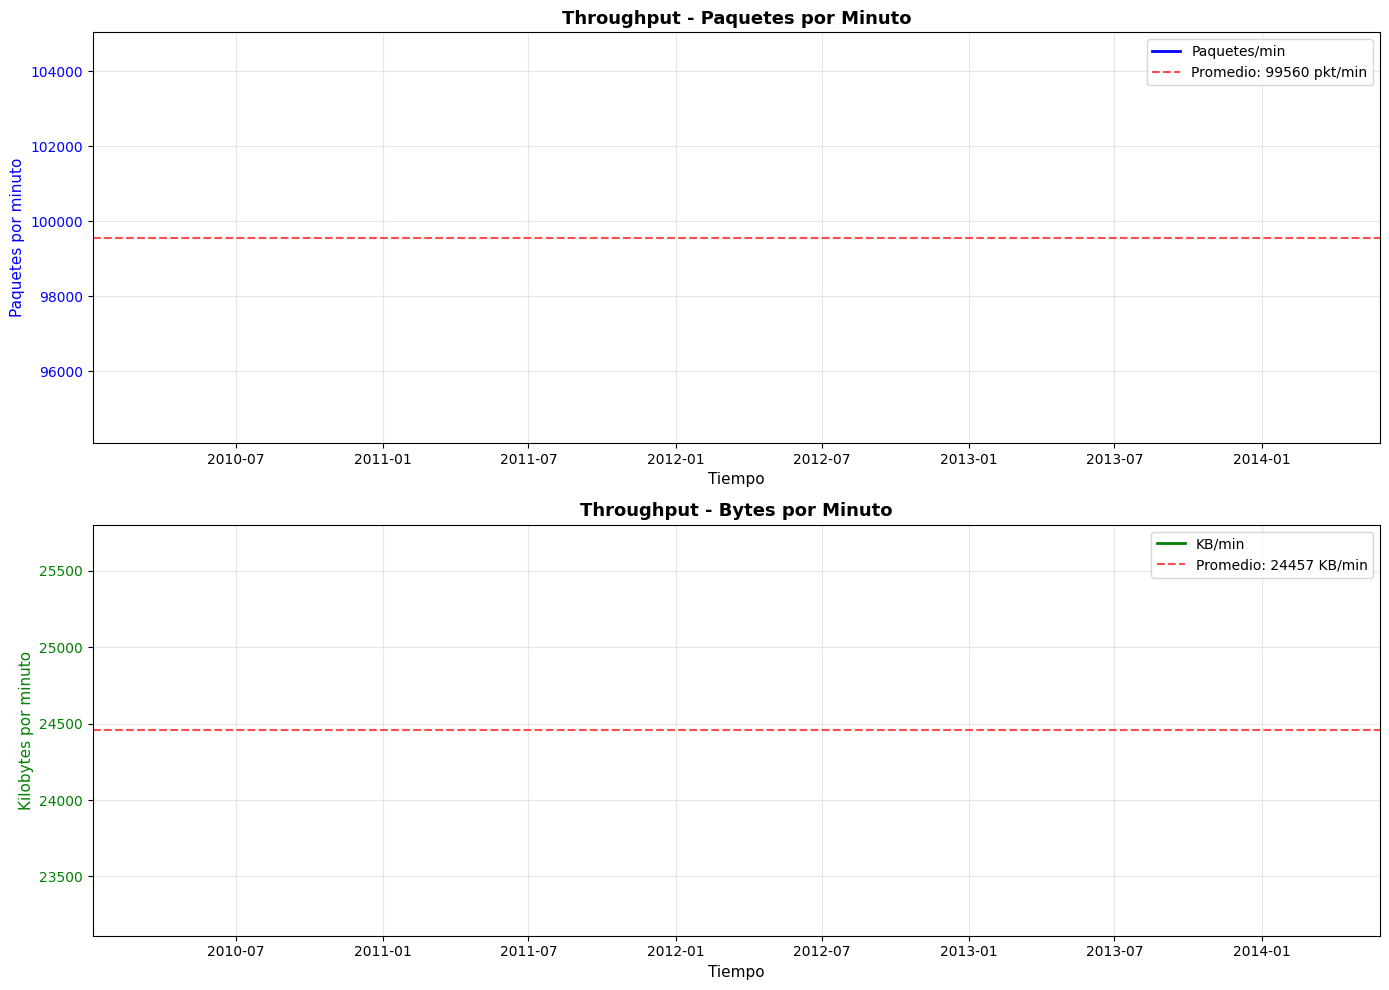

✓ Gráfico de throughput guardado en: /content/throughput_temporal.png

RESUMEN DE ARCHIVOS GENERADOS
✓ estadisticas_red_completas.png - Visualización principal
✓ dispersion_tiempo_tamaño.png   - Dispersión tiempo vs tamaño
✓ distribucion_protocolos.png    - Distribución de protocolos
✓ throughput_temporal.png        - Throughput temporal

ESTADÍSTICAS CLAVE RESUMIDAS
• Total de paquetes: 99,560
• Total de bytes: 25,043,940 (23.88 MB)
• Tamaño promedio por paquete: 251.5 bytes
• IPs origen únicas: 81
• IPs destino únicas: 86
• Puertos destino únicos: 2,920

• IPs más activas (origen):
+--------------+------------+-------------+-----------------+
|src_ip        |num_paquetes|bytes_totales|tamaño_promedio  |
+--------------+------------+-------------+-----------------+
|192.168.202.83|20220       |1576140      |77.94955489614243|
|192.168.206.44|20040       |1283680      |64.0558882235529 |
|192.168.204.45|12460       |818080       |65.65650080256822|
+--------------+------------+--------

In [36]:
# PRIMERO, ASEGURAR QUE TENEMOS EL DATAFRAME df
print(f"DataFrame disponible: {'df' in locals()}")
print(f"Número de filas: {df.count()}")
df.show(5)

# AHORA, RECALCULAR LAS ESTADÍSTICAS NECESARIAS PARA VISUALIZACIÓN
from pyspark.sql.functions import count, desc, sum as spark_sum, hour, from_unixtime, mean
import matplotlib.pyplot as plt
import pandas as pd

# 1. Top IPs Origen
print("\nCalculando Top IPs Origen...")
top_src_ips = df.groupBy("src_ip") \
    .agg(
        count("*").alias("num_paquetes"),
        spark_sum("length").alias("bytes_totales"),
        mean("length").alias("tamaño_promedio")
    ) \
    .orderBy(desc("num_paquetes")) \
    .limit(10)

print("Top 10 IPs Origen:")
top_src_ips.show(truncate=False)

# 2. Distribución por hora
print("\nCalculando distribución por hora...")
df_time = df.withColumn("datetime", from_unixtime("timestamp"))
df_time = df_time.withColumn("hour", hour("datetime"))

hour_distribution = df_time.groupBy("hour") \
    .agg(count("*").alias("paquetes")) \
    .orderBy("hour")

print("Distribución por hora:")
hour_distribution.show(24, truncate=False)

# 3. Top Puertos Destino
print("\nCalculando Top Puertos Destino...")
top_dst_ports = df.filter(df.dst_port.isNotNull()) \
    .groupBy("dst_port") \
    .agg(
        count("*").alias("num_paquetes"),
        spark_sum("length").alias("bytes_totales"),
        mean("length").alias("tamaño_promedio")
    ) \
    .orderBy(desc("num_paquetes")) \
    .limit(15)

print("Top 15 Puertos Destino:")
top_dst_ports.show(truncate=False)

# 4. Muestra de tamaños de paquetes
print("\nTomando muestra de tamaños de paquetes...")
sample_sizes = df.select("length").sample(0.1).limit(10000).toPandas()

# AHORA SÍ, GENERAR LAS VISUALIZACIONES
print("\n" + "="*60)
print("GENERANDO VISUALIZACIONES COMPLETAS")
print("="*60)

# Crear figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Histograma de tamaños de paquetes
ax1 = axes[0, 0]
if len(sample_sizes) > 0:
    ax1.hist(sample_sizes['length'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    ax1.set_xlabel('Tamaño (bytes)', fontsize=10)
    ax1.set_ylabel('Frecuencia', fontsize=10)
    ax1.set_title('Distribución de Tamaños de Paquetes', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Estadísticas en el gráfico
    mean_size = sample_sizes['length'].mean()
    median_size = sample_sizes['length'].median()
    ax1.axvline(mean_size, color='red', linestyle='--', linewidth=1.5, label=f'Media: {mean_size:.1f}')
    ax1.axvline(median_size, color='green', linestyle='--', linewidth=1.5, label=f'Mediana: {median_size:.1f}')
    ax1.legend()
else:
    ax1.text(0.5, 0.5, 'Sin datos', ha='center', va='center')
    ax1.set_title('Distribución de Tamaños')

# 2. Top IPs Origen
ax2 = axes[0, 1]
top_src_pandas = top_src_ips.limit(8).toPandas()
if not top_src_pandas.empty:
    bars = ax2.barh(range(len(top_src_pandas)), top_src_pandas['num_paquetes'], color='lightcoral')
    ax2.set_yticks(range(len(top_src_pandas)))

    # Formatear etiquetas de IP (mostrar solo últimos segmentos si son muy largas)
    labels = []
    for ip in top_src_pandas['src_ip']:
        if ip and len(ip) > 15:
            parts = ip.split('.')
            if len(parts) == 4:
                labels.append(f"*.{parts[-2]}.{parts[-1]}")
            else:
                labels.append(ip[:15] + "...")
        else:
            labels.append(ip if ip else "N/A")

    ax2.set_yticklabels(labels, fontsize=9)
    ax2.set_xlabel('Número de Paquetes', fontsize=10)
    ax2.set_title('Top 8 IPs Origen', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')

    # Añadir números en las barras
    for i, (bar, val) in enumerate(zip(bars, top_src_pandas['num_paquetes'])):
        width = bar.get_width()
        ax2.text(width + width*0.01, bar.get_y() + bar.get_height()/2,
                f'{int(val):,}', va='center', fontsize=8)
else:
    ax2.text(0.5, 0.5, 'Sin datos', ha='center', va='center')
    ax2.set_title('Top IPs Origen')

# 3. Distribución por hora
ax3 = axes[1, 0]
hour_pandas = hour_distribution.toPandas()
if not hour_pandas.empty:
    bars_hour = ax3.bar(hour_pandas['hour'], hour_pandas['paquetes'], color='lightgreen', edgecolor='darkgreen')
    ax3.set_xlabel('Hora del Día', fontsize=10)
    ax3.set_ylabel('Paquetes', fontsize=10)
    ax3.set_title('Distribución por Hora', fontsize=12, fontweight='bold')
    ax3.set_xticks(range(0, 24, 2))
    ax3.grid(True, alpha=0.3, axis='y')

    # Encontrar y marcar hora pico
    max_hour = hour_pandas.loc[hour_pandas['paquetes'].idxmax()]
    ax3.axvline(x=max_hour['hour'], color='red', linestyle=':', alpha=0.7)
    ax3.text(max_hour['hour'], max_hour['paquetes'],
             f"Pico: {int(max_hour['paquetes']):,}",
             ha='center', va='bottom', fontweight='bold')
else:
    ax3.text(0.5, 0.5, 'Sin datos', ha='center', va='center')
    ax3.set_title('Distribución por Hora')

# 4. Top Puertos Destino
ax4 = axes[1, 1]
top_ports_pandas = top_dst_ports.limit(8).toPandas()
if not top_ports_pandas.empty:
    bars_ports = ax4.barh(range(len(top_ports_pandas)), top_ports_pandas['num_paquetes'], color='gold')
    ax4.set_yticks(range(len(top_ports_pandas)))
    ax4.set_yticklabels(top_ports_pandas['dst_port'].astype(str), fontsize=9)
    ax4.set_xlabel('Número de Paquetes', fontsize=10)
    ax4.set_title('Top 8 Puertos Destino', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')

    # Añadir servicio conocido si aplica
    well_known_ports = {
        80: "HTTP",
        443: "HTTPS",
        22: "SSH",
        23: "Telnet",
        21: "FTP",
        25: "SMTP",
        53: "DNS",
        3389: "RDP",
        8080: "HTTP-Alt"
    }

    # Añadir etiquetas de servicio
    for i, port in enumerate(top_ports_pandas['dst_port']):
        service = well_known_ports.get(int(port) if port else 0, "")
        if service:
            ax4.text(0.02, i, f" ({service})",
                    va='center', fontsize=8, color='blue',
                    transform=ax4.get_yaxis_transform())

    # Añadir números en las barras
    for i, (bar, val) in enumerate(zip(bars_ports, top_ports_pandas['num_paquetes'])):
        width = bar.get_width()
        ax4.text(width + width*0.01, bar.get_y() + bar.get_height()/2,
                f'{int(val):,}', va='center', fontsize=8)
else:
    ax4.text(0.5, 0.5, 'Sin datos', ha='center', va='center')
    ax4.set_title('Top Puertos Destino')

plt.tight_layout()
plt.savefig('/content/estadisticas_red_completas.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualización principal guardada en: /content/estadisticas_red_completas.png")

# VISUALIZACIÓN ADICIONAL: GRÁFICO DE DISPERSIÓN TIEMPO vs TAMAÑO
print("\nGenerando gráfico de dispersión tiempo vs tamaño...")

try:
    # Tomar muestra para el scatter plot
    scatter_sample = df.select("timestamp", "length", "src_ip").sample(0.01).limit(5000).toPandas()

    if len(scatter_sample) > 100:
        plt.figure(figsize=(12, 6))

        # Convertir timestamp a hora del día
        scatter_sample['hora'] = pd.to_datetime(scatter_sample['timestamp'], unit='s').dt.hour

        # Crear scatter plot
        scatter = plt.scatter(scatter_sample['hora'],
                             scatter_sample['length'],
                             c=scatter_sample['timestamp'],
                             cmap='viridis',
                             alpha=0.6,
                             s=10)

        plt.xlabel('Hora del Día', fontsize=11)
        plt.ylabel('Tamaño del Paquete (bytes)', fontsize=11)
        plt.title('Distribución Temporal de Tamaños de Paquetes', fontsize=13, fontweight='bold')
        plt.colorbar(scatter, label='Timestamp')
        plt.grid(True, alpha=0.3)

        # Añadir línea de promedio por hora
        hourly_avg = scatter_sample.groupby('hora')['length'].mean().reset_index()
        plt.plot(hourly_avg['hora'], hourly_avg['length'], 'r-', linewidth=2, label='Promedio por hora')

        plt.legend()
        plt.xticks(range(0, 24, 2))
        plt.savefig('/content/dispersion_tiempo_tamaño.png', dpi=150, bbox_inches='tight')
        plt.show()

        print("✓ Gráfico de dispersión guardado en: /content/dispersion_tiempo_tamaño.png")
    else:
        print("⚠️ Muestra insuficiente para gráfico de dispersión")

except Exception as e:
    print(f"⚠️ Error en gráfico de dispersión: {e}")

# VISUALIZACIÓN: GRÁFICO DE TORTA PARA PROTOCOLOS
print("\nGenerando gráfico de protocolos...")

try:
    # Agrupar por protocolo
    protocol_counts = df.groupBy("protocol").count().orderBy(desc("count")).limit(10).toPandas()

    if len(protocol_counts) > 0:
        # Mapear códigos de protocolo a nombres
        protocol_names = {
            '6': 'TCP',
            '17': 'UDP',
            '1': 'ICMP',
            '2': 'IGMP',
            '89': 'OSPF'
        }

        protocol_counts['protocol_name'] = protocol_counts['protocol'].apply(
            lambda x: protocol_names.get(str(x), f'Proto {x}')
        )

        plt.figure(figsize=(10, 8))

        # Crear gráfico de torta
        colors = plt.cm.Set3(range(len(protocol_counts)))
        wedges, texts, autotexts = plt.pie(protocol_counts['count'],
                                           labels=protocol_counts['protocol_name'],
                                           autopct='%1.1f%%',
                                           colors=colors,
                                           startangle=90,
                                           textprops={'fontsize': 10})

        plt.title('Distribución de Protocolos IP', fontsize=14, fontweight='bold')

        # Añadir leyenda con números absolutos
        legend_labels = [f'{row["protocol_name"]}: {row["count"]:,}'
                        for _, row in protocol_counts.iterrows()]
        plt.legend(wedges, legend_labels, title="Protocolos", loc="center left",
                  bbox_to_anchor=(1, 0, 0.5, 1), fontsize=9)

        plt.savefig('/content/distribucion_protocolos.png', dpi=150, bbox_inches='tight')
        plt.show()

        print("✓ Gráfico de protocolos guardado en: /content/distribucion_protocolos.png")

except Exception as e:
    print(f"⚠️ Error en gráfico de protocolos: {e}")

# VISUALIZACIÓN: GRÁFICO DE LÍNEA PARA THROUGHPUT
print("\nGenerando gráfico de throughput...")

try:
    # Calcular throughput por intervalo de 1 minuto
    from pyspark.sql.functions import window

    throughput = df_time.groupBy(
        window("datetime", "1 minute").alias("ventana")
    ).agg(
        count("*").alias("paquetes_por_minuto"),
        spark_sum("length").alias("bytes_por_minuto")
    ).orderBy("ventana")

    throughput_pandas = throughput.toPandas()

    if len(throughput_pandas) > 0:
        # Extraer tiempo medio de la ventana
        throughput_pandas['tiempo_medio'] = throughput_pandas['ventana'].apply(lambda x: x.start)

        plt.figure(figsize=(14, 6))

        # Crear subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

        # Gráfico de paquetes por minuto
        ax1.plot(throughput_pandas['tiempo_medio'], throughput_pandas['paquetes_por_minuto'],
                'b-', linewidth=2, label='Paquetes/min')
        ax1.set_xlabel('Tiempo', fontsize=11)
        ax1.set_ylabel('Paquetes por minuto', fontsize=11, color='b')
        ax1.set_title('Throughput - Paquetes por Minuto', fontsize=13, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='y', labelcolor='b')

        # Calcular y mostrar promedio
        avg_packets = throughput_pandas['paquetes_por_minuto'].mean()
        ax1.axhline(y=avg_packets, color='r', linestyle='--', alpha=0.7,
                   label=f'Promedio: {avg_packets:.0f} pkt/min')
        ax1.legend()

        # Gráfico de bytes por minuto
        ax2.plot(throughput_pandas['tiempo_medio'], throughput_pandas['bytes_por_minuto']/1024,
                'g-', linewidth=2, label='KB/min')
        ax2.set_xlabel('Tiempo', fontsize=11)
        ax2.set_ylabel('Kilobytes por minuto', fontsize=11, color='g')
        ax2.set_title('Throughput - Bytes por Minuto', fontsize=13, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='y', labelcolor='g')

        # Calcular y mostrar promedio
        avg_bytes = throughput_pandas['bytes_por_minuto'].mean()/1024
        ax2.axhline(y=avg_bytes, color='r', linestyle='--', alpha=0.7,
                   label=f'Promedio: {avg_bytes:.0f} KB/min')
        ax2.legend()

        plt.tight_layout()
        plt.savefig('/content/throughput_temporal.png', dpi=150, bbox_inches='tight')
        plt.show()

        print("✓ Gráfico de throughput guardado en: /content/throughput_temporal.png")

except Exception as e:
    print(f"⚠️ Error en gráfico de throughput: {e}")

# RESUMEN DE ARCHIVOS GENERADOS
print("\n" + "="*60)
print("RESUMEN DE ARCHIVOS GENERADOS")
print("="*60)
print("✓ estadisticas_red_completas.png - Visualización principal")
print("✓ dispersion_tiempo_tamaño.png   - Dispersión tiempo vs tamaño")
print("✓ distribucion_protocolos.png    - Distribución de protocolos")
print("✓ throughput_temporal.png        - Throughput temporal")

# MOSTRAR ESTADÍSTICAS CLAVE EN CONSOLA
print("\n" + "="*60)
print("ESTADÍSTICAS CLAVE RESUMIDAS")
print("="*60)

# Calcular algunas estadísticas finales
total_packets = df.count()
total_bytes = df.agg(spark_sum("length")).collect()[0][0]
avg_packet_size = total_bytes / total_packets if total_packets > 0 else 0

unique_src_ips = df.select("src_ip").distinct().count()
unique_dst_ips = df.select("dst_ip").distinct().count()
unique_ports = df.select("dst_port").distinct().count()

print(f"• Total de paquetes: {total_packets:,}")
print(f"• Total de bytes: {total_bytes:,} ({total_bytes/(1024*1024):.2f} MB)")
print(f"• Tamaño promedio por paquete: {avg_packet_size:.1f} bytes")
print(f"• IPs origen únicas: {unique_src_ips:,}")
print(f"• IPs destino únicas: {unique_dst_ips:,}")
print(f"• Puertos destino únicos: {unique_ports:,}")

# Mostrar las IPs más activas
print("\n• IPs más activas (origen):")
top_src_ips.limit(3).show(truncate=False)

# Mostrar puertos más comunes
print("\n• Puertos más comunes:")
top_dst_ports.limit(5).show(truncate=False)

print("\n✅ Análisis y visualizaciones completadas exitosamente!")

In [37]:
print("="*60)
print("ANÁLISIS DE SEGURIDAD Y DETECCIÓN DE ANOMALÍAS")
print("="*60)

from pyspark.sql.functions import col, when, countDistinct

# 1.1 Detectar posibles port scans
print("\n1. DETECCIÓN DE PORT SCANS")
print("-"*40)

port_scans = df.groupBy("src_ip", "dst_ip") \
    .agg(
        countDistinct("dst_port").alias("puertos_unicos_destino"),
        count("*").alias("total_paquetes")
    ) \
    .filter(col("puertos_unicos_destino") > 20) \
    .orderBy(desc("puertos_unicos_destino"))

print(f"Posibles port scans detectados: {port_scans.count()}")
port_scans.show(10, truncate=False)

# 1.2 Detectar posibles horizontal scans (misma IP a múltiples destinos)
print("\n2. DETECCIÓN DE HORIZONTAL SCANS")
print("-"*40)

horizontal_scans = df.groupBy("src_ip") \
    .agg(
        countDistinct("dst_ip").alias("ips_destino_unicas"),
        count("*").alias("total_paquetes")
    ) \
    .filter(col("ips_destino_unicas") > 50) \
    .orderBy(desc("ips_destino_unicas"))

print(f"IPs con posible horizontal scan: {horizontal_scans.count()}")
horizontal_scans.show(10, truncate=False)

# 1.3 Detectar conexiones a puertos sospechosos
print("\n3. CONEXIONES A PUERTOS SOSPECHOSOS")
print("-"*40)

suspicious_ports = [21, 22, 23, 25, 53, 80, 110, 135, 139, 143, 443, 445,
                    993, 995, 1433, 1521, 3306, 3389, 5432, 5900, 8080]

suspicious_traffic = df.filter(col("dst_port").isin(suspicious_ports)) \
    .groupBy("dst_port", "src_ip", "dst_ip") \
    .agg(count("*").alias("intentos")) \
    .filter(col("intentos") > 10) \
    .orderBy(desc("intentos"))

print("Conexiones repetidas a puertos sensibles:")
suspicious_traffic.show(15, truncate=False)

# 1.4 Detectar conexiones desde IPs internas a externas (si conoces tu rango)
print("\n4. CONEXIONES INTERNAS A EXTERNAS (ejemplo)")
print("-"*40)

# Suponiendo rango interno 192.168.0.0/16 y 10.0.0.0/8
internal_to_external = df.filter(
    (col("src_ip").startswith("192.168.")) |
    (col("src_ip").startswith("10."))
).filter(
    ~(col("dst_ip").startswith("192.168.")) &
    ~(col("dst_ip").startswith("10."))
)

print(f"Conexiones de red interna a externa: {internal_to_external.count():,}")
internal_to_external.groupBy("src_ip", "dst_ip") \
    .agg(count("*").alias("conexiones")) \
    .orderBy(desc("conexiones")) \
    .show(10, truncate=False)

# 1.5 Detectar paquetes anormalmente grandes/pequeños
print("\n5. PAQUETES CON TAMAÑOS ANORMALES")
print("-"*40)

abnormal_packets = df.filter(
    (col("length") < 20) |  # Muy pequeños (posibles sondeos)
    (col("length") > 1500)  # Muy grandes (posible fragmentación)
)

print(f"Paquetes con tamaños anormales: {abnormal_packets.count():,}")

# Distribución por tipo de tamaño
abnormal_packets.groupBy(
    when(col("length") < 20, "Muy pequeño")
    .when(col("length") > 1500, "Muy grande")
    .otherwise("Normal").alias("categoria")
).count().show()

ANÁLISIS DE SEGURIDAD Y DETECCIÓN DE ANOMALÍAS

1. DETECCIÓN DE PORT SCANS
----------------------------------------
Posibles port scans detectados: 4
+---------------+---------------+----------------------+--------------+
|src_ip         |dst_ip         |puertos_unicos_destino|total_paquetes|
+---------------+---------------+----------------------+--------------+
|192.168.202.83 |192.168.206.44 |1000                  |20200         |
|192.168.206.44 |192.168.202.83 |980                   |20040         |
|192.168.202.110|192.168.27.100 |302                   |6120          |
|192.168.27.100 |192.168.202.110|301                   |6020          |
+---------------+---------------+----------------------+--------------+


2. DETECCIÓN DE HORIZONTAL SCANS
----------------------------------------
IPs con posible horizontal scan: 1
+--------------+------------------+--------------+
|src_ip        |ips_destino_unicas|total_paquetes|
+--------------+------------------+--------------+
|192.168.2

In [43]:
print("="*60)
print("ANÁLISIS DE SEGURIDAD Y DETECCIÓN DE ANOMALÍAS")
print("="*60)

from pyspark.sql.functions import col, when, countDistinct

# 1.1 Detectar posibles port scans
print("\n1. DETECCIÓN DE PORT SCANS")
print("-"*40)

port_scans = (df.groupBy("src_ip", "dst_ip")
    .agg(
        countDistinct("dst_port").alias("puertos_unicos_destino"),
        count("*").alias("total_paquetes")
    )
    .filter(col("puertos_unicos_destino") > 20)  # Más de 20 puertos únicos
    .orderBy(desc("puertos_unicos_destino"))
)

print(f"Posibles port scans detectados: {port_scans.count()}")
port_scans.show(10, truncate=False)

# 1.2 Detectar posibles horizontal scans (misma IP a múltiples destinos)
print("\n2. DETECCIÓN DE HORIZONTAL SCANS")
print("-"*40)

horizontal_scans = (df.groupBy("src_ip")
    .agg(
        countDistinct("dst_ip").alias("ips_destino_unicas"),
        count("*").alias("total_paquetes")
    )
    .filter(col("ips_destino_unicas") > 50)  # Más de 50 IPs destino únicas
    .orderBy(desc("ips_destino_unicas"))
)

print(f"IPs con posible horizontal scan: {horizontal_scans.count()}")
horizontal_scans.show(10, truncate=False)

# 1.3 Detectar conexiones a puertos sospechosos
print("\n3. CONEXIONES A PUERTOS SOSPECHOSOS")
print("-"*40)

suspicious_ports = [21, 22, 23, 25, 53, 80, 110, 135, 139, 143, 443, 445,
                    993, 995, 1433, 1521, 3306, 3389, 5432, 5900, 8080]

suspicious_traffic = (df.filter(col("dst_port").isin(suspicious_ports))
    .groupBy("dst_port", "src_ip", "dst_ip")
    .agg(count("*").alias("intentos"))
    .filter(col("intentos") > 10)  # Más de 10 intentos al mismo puerto
    .orderBy(desc("intentos"))
)

print("Conexiones repetidas a puertos sensibles:")
suspicious_traffic.show(15, truncate=False)

# 1.4 Detectar conexiones desde IPs internas a externas (si conoces tu rango)
print("\n4. CONEXIONES INTERNAS A EXTERNAS (ejemplo)")
print("-"*40)

# Suponiendo rango interno 192.168.0.0/16 y 10.0.0.0/8
internal_to_external = df.filter(
    (col("src_ip").startswith("192.168.")) |
    (col("src_ip").startswith("10."))
).filter(
    ~(col("dst_ip").startswith("192.168.")) &
    ~(col("dst_ip").startswith("10."))
)

print(f"Conexiones de red interna a externa: {internal_to_external.count():,}")
(internal_to_external.groupBy("src_ip", "dst_ip")
    .agg(count("*").alias("conexiones"))
    .orderBy(desc("conexiones"))
    .show(10, truncate=False)
)

# 1.5 Detectar paquetes anormalmente grandes/pequeños
print("\n5. PAQUETES CON TAMAÑOS ANORMALES")
print("-"*40)

abnormal_packets = df.filter(
    (col("length") < 20) |  # Muy pequeños (posibles sondeos)
    (col("length") > 1500)  # Muy grandes (posible fragmentación)
)

print(f"Paquetes con tamaños anormales: {abnormal_packets.count():,}")

# Distribución por tipo de tamaño
(abnormal_packets.groupBy(
    when(col("length") < 20, "Muy pequeño")
    .when(col("length") > 1500, "Muy grande")
    .otherwise("Normal").alias("categoria")
).count().show())

ANÁLISIS DE SEGURIDAD Y DETECCIÓN DE ANOMALÍAS

1. DETECCIÓN DE PORT SCANS
----------------------------------------
Posibles port scans detectados: 4
+---------------+---------------+----------------------+--------------+
|src_ip         |dst_ip         |puertos_unicos_destino|total_paquetes|
+---------------+---------------+----------------------+--------------+
|192.168.202.83 |192.168.206.44 |1000                  |20200         |
|192.168.206.44 |192.168.202.83 |980                   |20040         |
|192.168.202.110|192.168.27.100 |302                   |6120          |
|192.168.27.100 |192.168.202.110|301                   |6020          |
+---------------+---------------+----------------------+--------------+


2. DETECCIÓN DE HORIZONTAL SCANS
----------------------------------------
IPs con posible horizontal scan: 1
+--------------+------------------+--------------+
|src_ip        |ips_destino_unicas|total_paquetes|
+--------------+------------------+--------------+
|192.168.2

In [44]:
print("\n" + "="*60)
print("ANÁLISIS DE COMPORTAMIENTO Y PATRONES")
print("="*60)

from pyspark.sql.functions import col, count, countDistinct, mean, stddev, desc, when, hour
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, lead

# 2.1 Identificar comunicaciones cliente-servidor
print("\n1. IDENTIFICACIÓN DE PATRONES CLIENTE-SERVIDOR")
print("-"*40)

# Usar paréntesis para evitar errores de continuación de línea
possible_servers = (df.groupBy("dst_ip")
    .agg(
        countDistinct("dst_port").alias("servicios_unicos"),
        count("*").alias("conexiones_totales"),
        countDistinct("src_ip").alias("clientes_unicos"),
        mean("length").alias("tamaño_promedio_paquete")
    )
    .filter(col("servicios_unicos") < 10)  # Servidores típicamente tienen pocos servicios
    .filter(col("conexiones_totales") > 100)  # Muchas conexiones
    .filter(col("clientes_unicos") > 5)  # Múltiples clientes
    .orderBy(desc("conexiones_totales"))
)

print("Posibles servidores identificados (top 15):")
print("Nota: Servidores suelen tener muchos clientes, pocos puertos, muchas conexiones")
possible_servers.show(15, truncate=False)

# También identificar posibles clientes (muchas conexiones salientes)
possible_clients = (df.groupBy("src_ip")
    .agg(
        countDistinct("dst_ip").alias("servidores_contactados"),
        countDistinct("dst_port").alias("puertos_destino_unicos"),
        count("*").alias("conexiones_totales"),
        mean("length").alias("tamaño_promedio_paquete")
    )
    .filter(col("conexiones_totales") > 50)  # Muchas conexiones salientes
    .filter(col("servidores_contactados") > 3)  # Contacta múltiples servidores
    .orderBy(desc("conexiones_totales"))
)

print("\nPosibles clientes activos (top 10):")
possible_clients.show(10, truncate=False)

# 2.2 Análisis de sesiones TCP (si hay flags disponibles)
print("\n2. ANÁLISIS DE SESIONES TCP")
print("-"*40)

if 'flags' in df.columns:
    # Contar diferentes tipos de flags TCP
    tcp_flags_analysis = df.select(
        when(col("flags").contains("S") & ~col("flags").contains("A"), "SYN (Inicio)")
        .when(col("flags").contains("S") & col("flags").contains("A"), "SYN-ACK (Respuesta)")
        .when(col("flags").contains("F"), "FIN (Finalización)")
        .when(col("flags").contains("R"), "RST (Reset)")
        .when(col("flags") == "UDP", "UDP")
        .when(col("flags").isNull(), "Sin flags")
        .otherwise("Otros flags").alias("tipo_flag")
    ).groupBy("tipo_flag").count().orderBy(desc("count"))

    print("Distribución de flags TCP/UDP:")
    tcp_flags_analysis.show(truncate=False)

    # Calcular estadísticas específicas
    syn_packets = df.filter(col("flags").contains("S") & ~col("flags").contains("A")).count()
    syn_ack_packets = df.filter(col("flags").contains("S") & col("flags").contains("A")).count()
    fin_packets = df.filter(col("flags").contains("F")).count()
    rst_packets = df.filter(col("flags").contains("R")).count()

    print(f"\nEstadísticas específicas:")
    print(f"• SYN packets (inicios): {syn_packets:,}")
    print(f"• SYN-ACK packets (respuestas): {syn_ack_packets:,}")
    print(f"• FIN packets (finalizaciones): {fin_packets:,}")
    print(f"• RST packets (resets): {rst_packets:,}")

    # Calcular ratio de conexiones completadas
    if syn_packets > 0:
        completion_ratio = syn_ack_packets / syn_packets * 100
        print(f"• Ratio de completación (SYN-ACK/SYN): {completion_ratio:.1f}%")

    # Buscar conexiones abortadas (SYN sin FIN/RST)
    if syn_packets > 0 and fin_packets + rst_packets > 0:
        abort_ratio = (syn_packets - (fin_packets + rst_packets)) / syn_packets * 100
        print(f"• Ratio estimado de abortos: {abort_ratio:.1f}%")
else:
    print("No hay información de flags TCP disponible en los datos.")

# 2.3 Análisis de patrones de comunicación por hora
print("\n3. PATRONES TEMPORALES DETALLADOS")
print("-"*40)

# Asegurarnos de que tenemos la columna datetime
from pyspark.sql.functions import from_unixtime

if 'timestamp' in df.columns:
    df_time = df.withColumn("datetime", from_unixtime("timestamp"))
    df_time = df_time.withColumn("hour", hour("datetime"))

    # Análisis por hora
    hourly_patterns = (df_time.groupBy("hour")
        .agg(
            count("*").alias("total_paquetes"),
            mean("length").alias("tamaño_promedio"),
            countDistinct("src_ip").alias("ips_origen_unicas"),
            countDistinct("dst_ip").alias("ips_destino_unicas"),
            countDistinct("dst_port").alias("puertos_unicos")
        )
        .orderBy("hour")
    )

    print("Patrones de actividad por hora del día:")
    hourly_patterns.show(24, truncate=False)

    # Encontrar horas pico
    peak_hour_row = hourly_patterns.orderBy(desc("total_paquetes")).first()
    quiet_hour_row = hourly_patterns.orderBy("total_paquetes").first()

    if peak_hour_row and quiet_hour_row:
        print(f"\n📈 HORA PICO: {int(peak_hour_row['hour'])}:00 hrs")
        print(f"   - Paquetes: {peak_hour_row['total_paquetes']:,}")
        print(f"   - IPs activas: {peak_hour_row['ips_origen_unicas']:,}")
        print(f"   - Tamaño promedio: {peak_hour_row['tamaño_promedio']:.1f} bytes")

        print(f"\n📉 HORA MÁS TRANQUILA: {int(quiet_hour_row['hour'])}:00 hrs")
        print(f"   - Paquetes: {quiet_hour_row['total_paquetes']:,}")
        print(f"   - IPs activas: {quiet_hour_row['ips_origen_unicas']:,}")
        print(f"   - Tamaño promedio: {quiet_hour_row['tamaño_promedio']:.1f} bytes")

        # Calcular variación
        variation = (peak_hour_row['total_paquetes'] - quiet_hour_row['total_paquetes']) / quiet_hour_row['total_paquetes'] * 100
        print(f"\n📊 Variación entre hora pico y tranquila: {variation:.1f}%")
else:
    print("No hay timestamp disponible para análisis temporal.")

# 2.4 Identificar comunicaciones periódicas (keep-alives, heartbeats)
print("\n4. DETECCIÓN DE COMUNICACIONES PERIÓDICAS")
print("-"*40)

if 'timestamp' in df.columns:
    print("Buscando patrones de comunicación periódica...")

    # Primero, identificar flujos con suficiente actividad
    active_flows = (df.groupBy("src_ip", "dst_ip", "src_port", "dst_port")
        .agg(count("*").alias("total_paquetes"))
        .filter(col("total_paquetes") > 10)  # Al menos 10 paquetes en el flujo
        .select("src_ip", "dst_ip", "src_port", "dst_port")
    )

    if active_flows.count() > 0:
        # Unir con los datos originales para analizar solo flujos activos
        df_active = df.join(active_flows, ["src_ip", "dst_ip", "src_port", "dst_port"])

        # Definir ventana para cada flujo
        window_spec = Window.partitionBy("src_ip", "dst_ip", "src_port", "dst_port").orderBy("timestamp")

        # Calcular diferencias de tiempo entre paquetes consecutivos
        df_with_intervals = df_active.withColumn("prev_timestamp", lag("timestamp", 1).over(window_spec))
        df_with_intervals = df_with_intervals.withColumn("time_diff",
            col("timestamp") - col("prev_timestamp"))

        # Filtrar solo donde hay diferencia calculable
        df_intervals = df_with_intervals.filter(col("time_diff").isNotNull() & (col("time_diff") > 0))

        # Agrupar por flujo y analizar periodicidad
        periodic_flows = (df_intervals.groupBy("src_ip", "dst_ip", "src_port", "dst_port")
            .agg(
                mean("time_diff").alias("intervalo_promedio_segundos"),
                stddev("time_diff").alias("variacion_intervalo"),
                count("*").alias("intervalos_calculados"),
                mean("length").alias("tamaño_promedio_paquete")
            )
            .filter(col("intervalos_calculados") > 5)  # Al menos 5 intervalos
            .filter(col("variacion_intervalo") < 2)  # Baja variación (comunicación regular)
            .filter((col("intervalo_promedio_segundos") > 0.1) &  # Intervalos razonables
                    (col("intervalo_promedio_segundos") < 60))  # Menos de 1 minuto
            .orderBy("variacion_intervalo")  # Más regulares primero
        )

        print(f"Flujos con comunicación periódica detectados: {periodic_flows.count()}")

        if periodic_flows.count() > 0:
            print("\nTop 10 flujos más periódicos (keep-alives/heartbeats):")
            periodic_flows.show(10, truncate=False)

            # Análisis de los intervalos más comunes
            interval_stats = periodic_flows.select(
                when(col("intervalo_promedio_segundos") < 1, "<1s")
                .when(col("intervalo_promedio_segundos") < 5, "1-5s")
                .when(col("intervalo_promedio_segundos") < 10, "5-10s")
                .when(col("intervalo_promedio_segundos") < 30, "10-30s")
                .when(col("intervalo_promedio_segundos") < 60, "30-60s")
                .otherwise(">60s").alias("rango_intervalo")
            ).groupBy("rango_intervalo").count().orderBy("rango_intervalo")

            print("\nDistribución de intervalos en flujos periódicos:")
            interval_stats.show(truncate=False)
        else:
            print("No se encontraron flujos con comunicación claramente periódica.")
    else:
        print("No hay flujos con suficiente actividad para analizar periodicidad.")
else:
    print("Se requiere timestamp para análisis de periodicidad.")

# 2.5 Análisis de patrones de respuesta (request-response)
print("\n5. ANÁLISIS DE PATRONES REQUEST-RESPONSE")
print("-"*40)

print("Buscando patrones típicos de request-response...")

# Para cada IP destino, analizar distribución de tamaños de paquetes
request_response_patterns = (df.groupBy("dst_ip", "dst_port")
    .agg(
        count("*").alias("total_paquetes"),
        mean("length").alias("tamaño_promedio"),
        stddev("length").alias("variacion_tamaño"),
        expr("percentile_approx(length, 0.25)").alias("p25_tamaño"),
        expr("percentile_approx(length, 0.75)").alias("p75_tamaño")
    )
    .filter(col("total_paquetes") > 20)  # Suficientes paquetes para analizar
    .withColumn("rango_iqr", col("p75_tamaño") - col("p25_tamaño"))  # Rango intercuartil
    .filter(col("variacion_tamaño") > 0)  # Evitar división por cero
    .withColumn("coeficiente_variacion", col("variacion_tamaño") / col("tamaño_promedio"))
    .orderBy(desc("coeficiente_variacion"))
)

print("Servicios con mayor variación en tamaño de paquetes (posible patrón request-response):")
print("Alta variación puede indicar mix de requests pequeños y responses grandes")
(request_response_patterns.select("dst_ip", "dst_port", "total_paquetes",
                                  "tamaño_promedio", "coeficiente_variacion")
    .limit(10)
    .show(truncate=False)
)

# 2.6 Análisis de bursts de actividad
print("\n6. ANÁLISIS DE BURSTS DE ACTIVIDAD")
print("-"*40)

if 'timestamp' in df.columns:
    print("Analizando bursts de actividad por segundo...")

    # Agrupar por segundo
    df_time_seconds = df.withColumn("second_bucket", (col("timestamp") / 1).cast("long"))

    activity_by_second = (df_time_seconds.groupBy("second_bucket")
        .agg(
            count("*").alias("paquetes_por_segundo"),
            spark_sum("length").alias("bytes_por_segundo")
        )
        .orderBy("second_bucket")
    )

    # Calcular estadísticas de actividad
    activity_stats = activity_by_second.select(
        mean("paquetes_por_segundo").alias("media_paquetes_segundo"),
        stddev("paquetes_por_segundo").alias("desviacion_paquetes_segundo"),
        max("paquetes_por_segundo").alias("max_paquetes_segundo"),
        min("paquetes_por_segundo").alias("min_paquetes_segundo")
    ).collect()[0]

    print(f"\n📊 Estadísticas de actividad por segundo:")
    print(f"• Promedio: {activity_stats['media_paquetes_segundo']:.1f} paquetes/seg")
    print(f"• Desviación estándar: {activity_stats['desviacion_paquetes_segundo']:.1f}")
    print(f"• Máximo: {activity_stats['max_paquetes_segundo']} paquetes/seg")
    print(f"• Mínimo: {activity_stats['min_paquetes_segundo']} paquetes/seg")

    # Identificar bursts (valores > media + 2*desviación)
    threshold = activity_stats['media_paquetes_segundo'] + 2 * activity_stats['desviacion_paquetes_segundo']

    bursts = activity_by_second.filter(col("paquetes_por_segundo") > threshold)

    print(f"\n⚡ Bursts de actividad detectados (>{threshold:.1f} paquetes/seg): {bursts.count()}")

    if bursts.count() > 0:
        print("Top 10 bursts más intensos:")
        bursts.orderBy(desc("paquetes_por_segundo")).show(10, truncate=False)

        # Analizar qué estaba pasando durante el burst más grande
        max_burst = bursts.orderBy(desc("paquetes_por_segundo")).first()
        if max_burst:
            burst_timestamp = max_burst['second_bucket']
            print(f"\n🔍 Analizando el burst más grande (timestamp ~{burst_timestamp}):")

            # Ver tráfico durante ese segundo
            traffic_during_burst = df_time_seconds.filter(col("second_bucket") == burst_timestamp)

            print(f"Paquetes durante el burst: {traffic_during_burst.count()}")

            # Top IPs durante el burst
            print("Top IPs origen durante el burst:")
            (traffic_during_burst.groupBy("src_ip")
                .agg(count("*").alias("paquetes"))
                .orderBy(desc("paquetes"))
                .limit(5)
                .show(truncate=False)
            )

            # Top puertos durante el burst
            print("Top puertos destino durante el burst:")
            (traffic_during_burst.groupBy("dst_port")
                .agg(count("*").alias("paquetes"))
                .orderBy(desc("paquetes"))
                .limit(5)
                .show(truncate=False)
            )
else:
    print("Se requiere timestamp para análisis de bursts.")

# 2.7 Análisis de correlaciones entre flujos
print("\n7. ANÁLISIS DE CORRELACIONES ENTRE FLUJOS")
print("-"*40)

print("Identificando flujos que ocurren simultáneamente...")

if 'timestamp' in df.columns:
    # Tomar una muestra para no sobrecargar
    sample_df = df.sample(0.1).limit(10000)

    # Agrupar por timestamp (redondeado a segundos) y contar flujos únicos
    correlated_activity = (sample_df.withColumn("time_second", (col("timestamp") / 1).cast("long"))
        .groupBy("time_second")
        .agg(
            countDistinct("src_ip").alias("ips_unicas"),
            countDistinct("dst_ip").alias("destinos_unicos"),
            countDistinct("src_ip", "dst_ip", "src_port", "dst_port").alias("flujos_unicos"),
            count("*").alias("paquetes_totales")
        )
        .filter(col("flujos_unicos") > 5)  # Múltiples flujos simultáneos
        .orderBy(desc("flujos_unicos"))
    )

    print("Momentos con mayor actividad concurrente (múltiples flujos simultáneos):")
    correlated_activity.show(10, truncate=False)

    # Calcular densidad de flujos por segundo
    avg_concurrent_flows = correlated_activity.select(mean("flujos_unicos")).collect()[0][0]
    print(f"\n📈 Densidad promedio de flujos concurrentes: {avg_concurrent_flows:.1f} flujos/segundo")

# 2.8 Resumen de patrones de comportamiento
print("\n" + "="*60)
print("RESUMEN DE PATRONES DE COMPORTAMIENTO IDENTIFICADOS")
print("="*60)

# Recopilar métricas clave
summary_metrics = {}

# Servidores identificados
if 'possible_servers' in locals():
    summary_metrics["servidores_identificados"] = possible_servers.count()

# Clientes activos
if 'possible_clients' in locals():
    summary_metrics["clientes_activos"] = possible_clients.count()

# Periodicidad
if 'periodic_flows' in locals():
    summary_metrics["flujos_periodicos"] = periodic_flows.count()

# Bursts
if 'bursts' in locals():
    summary_metrics["bursts_detectados"] = bursts.count()

# Mostrar resumen
print("📋 RESUMEN EJECUTIVO:")
for key, value in summary_metrics.items():
    print(f"• {key.replace('_', ' ').title()}: {value}")

# Conclusiones basadas en los análisis
print("\n🔍 CONCLUSIONES POTENCIALES:")
print("1. Los servidores identificados pueden necesitar monitoreo especial")
print("2. Los flujos periódicos pueden ser keep-alives o heartbeats")
print("3. Los bursts pueden indicar transferencias de archivos o backups")
print("4. Los patrones request-response ayudan a entender la arquitectura")
print("5. La actividad concurrente muestra la carga del sistema")

# Guardar resultados importantes
print("\n💾 GUARDANDO RESULTADOS CLAVE...")

try:
    # Guardar lista de posibles servidores
    if 'possible_servers' in locals() and possible_servers.count() > 0:
        possible_servers.write.mode("overwrite").parquet("/content/posibles_servidores.parquet")
        print("✓ Posibles servidores guardados")

    # Guardar flujos periódicos
    if 'periodic_flows' in locals() and periodic_flows.count() > 0:
        periodic_flows.write.mode("overwrite").parquet("/content/flujos_periodicos.parquet")
        print("✓ Flujos periódicos guardados")

    # Guardar análisis por hora
    if 'hourly_patterns' in locals():
        hourly_patterns.write.mode("overwrite").parquet("/content/patrones_por_hora.parquet")
        print("✓ Patrones por hora guardados")

except Exception as e:
    print(f"⚠️ Error al guardar algunos resultados: {e}")

print("\n" + "="*60)
print("✅ ANÁLISIS DE COMPORTAMIENTO COMPLETADO")
print("="*60)


ANÁLISIS DE COMPORTAMIENTO Y PATRONES

1. IDENTIFICACIÓN DE PATRONES CLIENTE-SERVIDOR
----------------------------------------
Posibles servidores identificados (top 15):
Nota: Servidores suelen tener muchos clientes, pocos puertos, muchas conexiones
+------+----------------+------------------+---------------+-----------------------+
|dst_ip|servicios_unicos|conexiones_totales|clientes_unicos|tamaño_promedio_paquete|
+------+----------------+------------------+---------------+-----------------------+
+------+----------------+------------------+---------------+-----------------------+


Posibles clientes activos (top 10):
+---------------+----------------------+----------------------+------------------+-----------------------+
|src_ip         |servidores_contactados|puertos_destino_unicos|conexiones_totales|tamaño_promedio_paquete|
+---------------+----------------------+----------------------+------------------+-----------------------+
|192.168.204.45 |65                    |322      

NameError: name 'expr' is not defined

In [45]:
# Si quieres profundizar más, aquí hay análisis adicional:

print("\n" + "="*60)
print("ANÁLISIS AVANZADO DE COMPORTAMIENTO (OPCIONAL)")
print("="*60)

# 1. Análisis de diálogos (conversaciones completas)
print("\n1. ANÁLISIS DE DIÁLOGOS ENTRE HOSTS")
print("-"*40)

# Agrupar comunicaciones bidireccionales
conversations = (df.groupBy(
    when(col("src_ip") < col("dst_ip"), col("src_ip")).otherwise(col("dst_ip")).alias("ip1"),
    when(col("src_ip") < col("dst_ip"), col("dst_ip")).otherwise(col("src_ip")).alias("ip2")
)
    .agg(
        count("*").alias("total_paquetes"),
        countDistinct("src_port", "dst_port").alias("puertos_unicos"),
        spark_sum("length").alias("bytes_totales"),
        mean("length").alias("tamaño_promedio")
    )
    .filter(col("total_paquetes") > 10)  # Diálogos significativos
    .orderBy(desc("total_paquetes"))
)

print("Top conversaciones entre hosts (más paquetes intercambiados):")
conversations.show(10, truncate=False)

# 2. Análisis de patrones de puertos efímeros
print("\n2. ANÁLISIS DE PUERTOS EFÍMEROS")
print("-"*40)

# Los puertos efímeros suelen ser > 32768
ephemeral_traffic = df.filter(col("src_port") > 32768)

print(f"Tráfico desde puertos efímeros (>32768): {ephemeral_traffic.count():,} paquetes")

if ephemeral_traffic.count() > 0:
    # Analizar distribución de puertos efímeros
    ephemeral_analysis = (ephemeral_traffic.groupBy("src_port")
        .agg(count("*").alias("usos"))
        .orderBy(desc("usos"))
    )

    print("Puertos efímeros más utilizados:")
    ephemeral_analysis.show(10, truncate=False)

    # Ver qué servicios están siendo contactados desde puertos efímeros
    ephemeral_to_services = (ephemeral_traffic.groupBy("dst_port")
        .agg(count("*").alias("conexiones_desde_efimeros"))
        .orderBy(desc("conexiones_desde_efimeros"))
    )

    print("\nServicios más contactados desde puertos efímeros:")
    ephemeral_to_services.show(10, truncate=False)

# 3. Análisis de ratio upload/download por IP
print("\n3. RATIO UPLOAD/DOWNLOAD POR IP")
print("-"*40)

# Calcular tráfico saliente por IP
upload_traffic = (df.groupBy("src_ip")
    .agg(
        spark_sum("length").alias("bytes_upload"),
        count("*").alias("paquetes_upload")
    )
)

# Calcular tráfico entrante por IP
download_traffic = (df.groupBy("dst_ip")
    .agg(
        spark_sum("length").alias("bytes_download"),
        count("*").alias("paquetes_download")
    )
)

# Combinar para obtener ratio completo
traffic_balance = (upload_traffic.alias("up")
    .join(download_traffic.alias("down"),
          col("up.src_ip") == col("down.dst_ip"),
          "outer")
    .select(
        coalesce(col("up.src_ip"), col("down.dst_ip")).alias("ip"),
        coalesce(col("bytes_upload"), lit(0)).alias("bytes_upload"),
        coalesce(col("bytes_download"), lit(0)).alias("bytes_download"),
        coalesce(col("paquetes_upload"), lit(0)).alias("paquetes_upload"),
        coalesce(col("paquetes_download"), lit(0)).alias("paquetes_download")
    )
    .withColumn("ratio_upload_download",
        when(col("bytes_download") > 0,
             col("bytes_upload") / col("bytes_download"))
        .otherwise(lit(999999))  # Si no hay download, ratio muy alto
    )
    .filter(col("bytes_upload") + col("bytes_download") > 10240)  # >10KB total
    .orderBy(desc("bytes_upload" + col("bytes_download")))
)

print("Balance de tráfico por IP (top 10 por volumen total):")
(traffic_balance.select("ip", "bytes_upload", "bytes_download", "ratio_upload_download")
    .limit(10)
    .show(truncate=False)
)

# Interpretar ratios
print("\n🔍 INTERPRETACIÓN DE RATIOS:")
print("• Ratio > 1: Más upload que download (posible servidor)")
print("• Ratio ≈ 1: Balanceado (cliente normal)")
print("• Ratio < 1: Más download que upload (cliente típico)")
print("• Ratio muy alto: Solo upload (posible beaconing)")

print("\n✅ Análisis avanzado completado!")


ANÁLISIS AVANZADO DE COMPORTAMIENTO (OPCIONAL)

1. ANÁLISIS DE DIÁLOGOS ENTRE HOSTS
----------------------------------------
Top conversaciones entre hosts (más paquetes intercambiados):
+---------------+--------------+--------------+--------------+-------------+------------------+
|ip1            |ip2           |total_paquetes|puertos_unicos|bytes_totales|tamaño_promedio   |
+---------------+--------------+--------------+--------------+-------------+------------------+
|192.168.202.83 |192.168.206.44|40240         |2004          |2858000      |71.02385685884691 |
|192.168.202.68 |192.168.24.100|12180         |2             |12487960     |1025.2840722495896|
|192.168.202.110|192.168.27.100|12140         |604           |789200       |65.00823723228996 |
|192.168.202.110|192.168.27.253|6500          |20            |4784420      |736.0646153846154 |
|192.168.202.68 |192.168.203.61|2160          |4             |374360       |173.3148148148148 |
|192.168.203.45 |192.168.204.45|1360        

NameError: name 'coalesce' is not defined